In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
%matplotlib inline

In [ ]:
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "dataset2"
IMAGES_PATH = os.path.sep.join(['/content/drive/MyDrive/object-detection-notebooks-main/dataset2', "images"])
ANNOTS_PATH = os.path.sep.join(['/content/drive/MyDrive/object-detection-notebooks-main/dataset2', "annotations"])

initialize the list of data (images), class labels, target bounding box coordinates, and image paths

In [ ]:
data = []
labels = []
bboxes = []
imagePaths = []

In [ ]:
csvPaths = []
for (rootDir, dirNames, filenames) in os.walk(ANNOTS_PATH):
    # loop over the filenames in the current directory
    for filename in filenames:
        # determine the file extension of the current file
        ext = filename[filename.rfind("."):].lower()

        # check to see if the file is an image and should be processed
        if ext.endswith(".csv"):
            # construct the path to the image and yield it
            csvPath = os.path.join(rootDir, filename)
            csvPaths.append(csvPath)

csvPaths

['/content/drive/MyDrive/object-detection-notebooks-main/dataset2/annotations/motorcycle.csv',
 '/content/drive/MyDrive/object-detection-notebooks-main/dataset2/annotations/face.csv',
 '/content/drive/MyDrive/object-detection-notebooks-main/dataset2/annotations/airplane.csv']

In [ ]:
# loop over all CSV files in the annotations directory
for csvPath in csvPaths:
    # load the contents of the current CSV annotations file
    rows = open(csvPath).read().strip().split("\n")

    # loop over the rows
    for row in rows:
        # break the row into the filename, bounding box coordinates,
        # and class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row

        # derive the path to the input image, load the image (in
        # OpenCV format), and grab its dimensions
        imagePath = os.path.sep.join([IMAGES_PATH, label, filename])
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]

        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # update our list of data, class labels, bounding boxes, and
        # image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

In [ ]:
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))


In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [ ]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

# train the network for bounding box regression and class label
# prediction
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=5,
    verbose=1)

Epoch 1/5
51/51 [==============================] - 904s 18s/step - loss: 0.0021 - bounding_box_loss: 6.2407e-04 - class_label_loss: 0.0015 - bounding_box_accuracy: 0.8967 - class_label_accuracy: 1.0000 - val_loss: 0.0013 - val_bounding_box_loss: 8.5280e-04 - val_class_label_loss: 4.0718e-04 - val_bounding_box_accuracy: 0.8870 - val_class_label_accuracy: 1.0000
Epoch 2/5
51/51 [==============================] - 903s 18s/step - loss: 0.0014 - bounding_box_loss: 5.1066e-04 - class_label_loss: 8.4365e-04 - bounding_box_accuracy: 0.8998 - class_label_accuracy: 1.0000 - val_loss: 0.0011 - val_bounding_box_loss: 8.0925e-04 - val_class_label_loss: 2.8730e-04 - val_bounding_box_accuracy: 0.8747 - val_class_label_accuracy: 1.0000
Epoch 3/5
51/51 [==============================] - 903s 18s/step - loss: 0.0013 - bounding_box_loss: 4.2561e-04 - class_label_loss: 9.0140e-04 - bounding_box_accuracy: 0.9028 - class_label_accuracy: 1.0000 - val_loss: 0.0011 - val_bounding_box_loss: 8.0231e-04 - val_cla

In [ ]:
model.save('3.h5', save_format="h5")
with open('lb3.pickle', "wb") as f:
    f.write(pickle.dumps(lb))

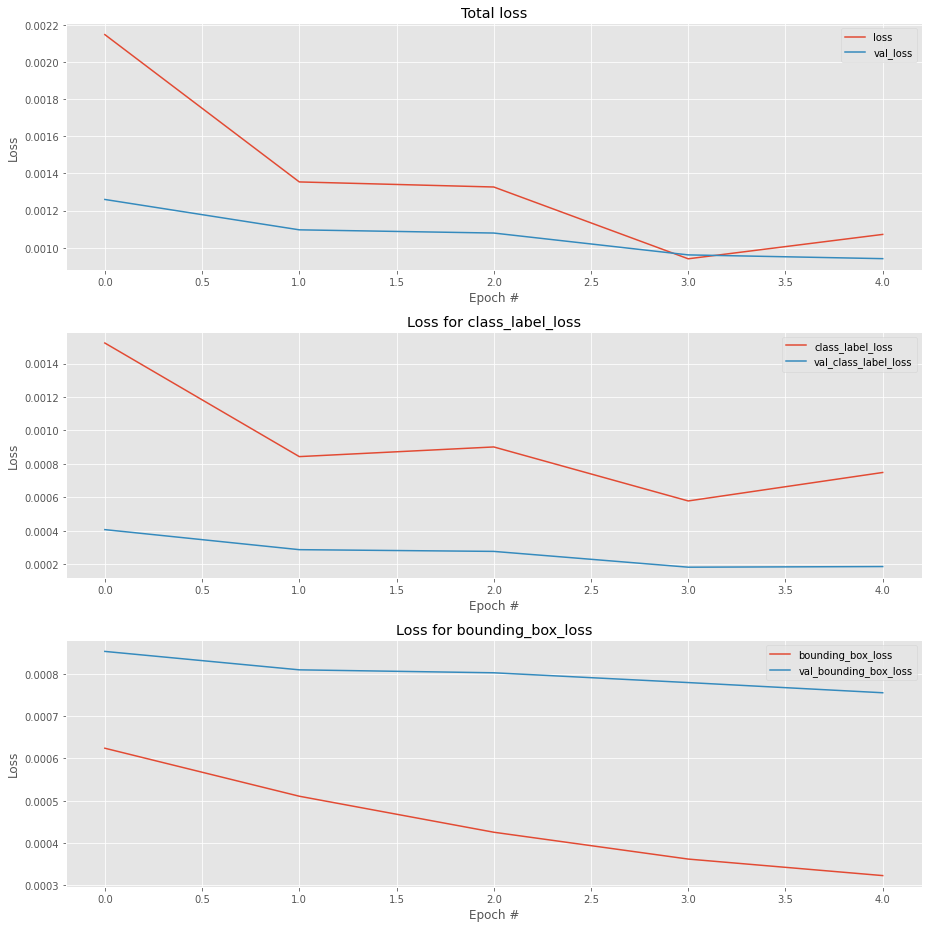

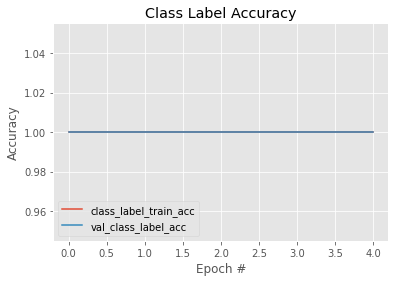

In [ ]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, H.params['epochs'])
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"], label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"], label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")